In [1]:
!pip install opencv-python
!pip install numpy
!pip install typing
!pip install scikit-learn

In [2]:
import cv2
import numpy as np
from typing import Tuple, List
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

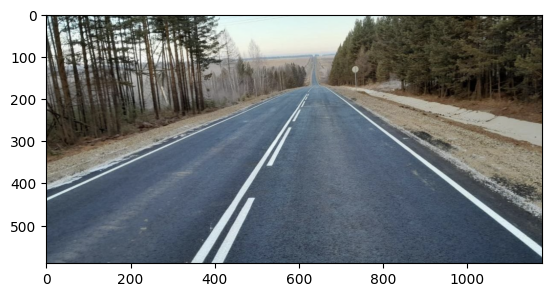

In [3]:
image = cv2.imread('../input/road1.png')
image_copy = image.copy()

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## Prepocessing

In [4]:
def convert_to_hls(img: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

def isolate_white_color(hsl_img: np.ndarray, img: np.ndarray ) -> np.ndarray:
    lower_white = np.array([0, 200, 0], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)

    white_mask = cv2.inRange(hsl_img, lower_white, upper_white)
    return cv2.bitwise_and(img, img, mask=white_mask)

def gaussianBlur(img: np.ndarray) -> np.ndarray:
    return cv2.GaussianBlur(img, (5, 5), 0)

## Lines

In [5]:
def getbordersCanny(img: np.ndarray) -> np.ndarray:
    return cv2.Canny(img, 100, 200)

def limit_field_of_view(img: np.ndarray) -> np.ndarray:
    height, width = img.shape[:2]

    # Building a mask for an interest area.
    mask = np.zeros((height, width), dtype=np.uint8)

    new_width = int(width)

    # 1.5 times increase in height.
    new_height = int(height * 1.5)

    # Shifting the area of interest down.
    roi_y = (new_height - height) // 2

    # Shifting the area of interest to the right.
    roi_x = (width - new_width) // 2

    # Offset from the left side by 520 pixels.
    roi_corners = np.array([[(roi_x + 520, roi_y),
                            (width - roi_x, roi_y),
                            (width - roi_x, new_height),
                            (roi_x, new_height)]], dtype=np.int32)

    cv2.fillPoly(mask, roi_corners, 255)

    return cv2.bitwise_and(img, img, mask=mask)

def get_Huff_lines(img: np.ndarray) -> np.ndarray:
    return cv2.HoughLinesP(img, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=20)

## Line selection



The identified lines are grouped into two clusters, separating those belonging to the right and left road markings. Subsequently, a central line is calculated for each cluster by averaging the coordinates of the lines within that cluster.

In [6]:
def extract_features(lines: np.ndarray) -> np.ndarray:
    features = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        angle = np.arctan2(y2 - y1, x2 - x1)
        features.append([x1, y1, x2, y2, length, angle])
    return np.array(features)

def get_clusters_lines(lines: np.ndarray) -> list:
    kmeans = KMeans(n_clusters=2)
    features = extract_features(lines)
    kmeans.fit(features)
    clusters = [[] for _ in range(kmeans.n_clusters)]

    for i, line in enumerate(lines):
        cluster_idx = kmeans.labels_[i]
        clusters[cluster_idx].append(line)

    return clusters

In [7]:
def find_middle_line(lines: list) -> list:
    start_points = np.mean([line[0][:2] for line in lines], axis=0)
    end_points = np.mean([line[0][2:] for line in lines], axis=0)

    middle_point = tuple(((start_points + end_points) / 2).astype(int))

    angle = np.arctan2(end_points[1] - start_points[1], end_points[0] - start_points[0])

    length = 280

    # Start
    x1 = middle_point[0] - int(length * np.cos(angle))
    y1 = middle_point[1] - int(length * np.sin(angle))

    # End
    x2 = middle_point[0] + int(length * np.cos(angle))
    y2 = middle_point[1] + int(length * np.sin(angle))

    return [x1, y1, x2, y2]

def get_center_lines(clusters: list ) -> list:
    center_lines = []
    for cluster in clusters:
        center_lines.append(find_middle_line(cluster))
    return center_lines

## Intersection point

In [8]:
def find_intersection(center_lines: list) -> Tuple[int, int]:
    x1, y1, x2, y2 = center_lines[0]
    x3, y3, x4, y4 = center_lines[1]

    # Angular coefficients
    m1 = (y2 - y1) / (x2 - x1) if (x2 - x1) != 0 else float('inf')
    m2 = (y4 - y3) / (x4 - x3) if (x4 - x3) != 0 else float('inf')


    if m1 == m2:
        return None # lines are parallel

    if m1 == float('inf'):
        x = x1
        y = m2 * (x - x3) + y3
    elif m2 == float('inf'):
        x = x3
        y = m1 * (x - x1) + y1
    else:
        x = ((m1 * x1 - y1) - (m2 * x3 - y3)) / (m1 - m2)
        y = m1 * (x - x1) + y1

    return int(x), int(y)

## Draw

In [9]:
def draw_result(img: np.ndarray, lines: list, intersection_point: Tuple[int, int]) -> None:
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 10)

    cv2.circle(img, tuple(intersection_point), 15, (0, 165, 255), -1)

def save_image(img: np.ndarray, name: str) -> None:
    cv2.imwrite(name, img)

## Visualization of results

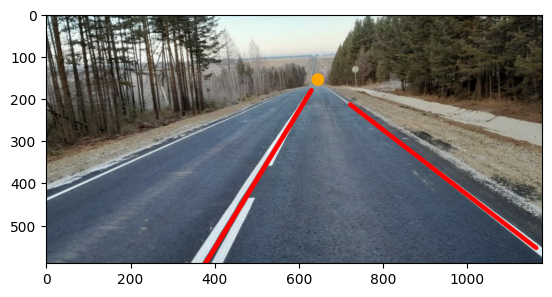

In [10]:
result_image = convert_to_hls(image_copy)
result_image = isolate_white_color(result_image, image_copy)
result_image = gaussianBlur(result_image)
result_image = getbordersCanny(result_image)
result_image = limit_field_of_view(result_image)
result_lines = get_Huff_lines(result_image)

clusters = get_clusters_lines(result_lines)

center_lines = get_center_lines(clusters)
intersection_point = find_intersection(center_lines)

draw_result(image, center_lines, intersection_point)
save_image(image, '../output/result_road1.png')

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

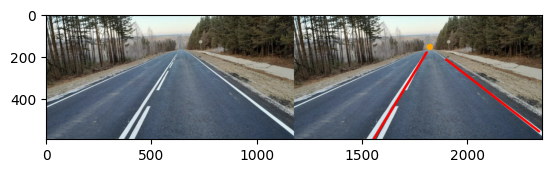

In [11]:
image_origin = cv2.imread('../input/road1.png')
combined_image = cv2.hconcat([image_origin, image])
save_image(combined_image, '../output/result_road1_combined.png')

plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
plt.show()